## 1. Basic import

In [83]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, permutation_test_score, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pickle

## 2. Creation of dataset : features and labels 

In [24]:
tracking = pd.read_pickle('MLbodyFace').dropna()
database = pd.read_pickle('database').reset_index()

In [25]:
tracking.drop(['seq', 'id', 'traSeq', 'trackId', 'rgbSeq'], axis=1, inplace=True)

In [26]:
database.rename(columns={'index': 'name'}, inplace=True)

#### We prepare the other dataset to be append to the big one

In [27]:
sabrine = pd.read_pickle('sabrine')

In [28]:
# Remove useless column - so both DataFrame have the same column 
sabrine.drop(['seq', 'id', 'traSeq', 'trackId', 'rgbSeq'], axis=1, inplace=True)
sabrine.rename(columns={'name': 'GroundTrue'}, inplace=True)

### Height normalization

As max height equal 2.3 and min height is 1.3, we just have to shift it to have value in [-0.5, 0.5] and multiply the value by 2 to have value in [-1, 1] 

In [29]:
tracking.height = tracking.height.apply(lambda x : (x - 1.8)*2)
database.height = database.height.apply(lambda x : (x - 1.8)*2)
sabrine.height = sabrine.height.apply(lambda x : (x - 1.8)*2)

### Extraction of embeddings information into different column to feed model

In [30]:
#Extract embedding informations and rearrange it into columns 
#(one column for each features - 128 columns in total)
em = [[] for i in range(len(tracking.iloc[0].embedding))]

for index, r in tracking.iterrows():
    for column in range (len(tracking.iloc[0].embedding)):
         em[column].append(r.embedding[column])

In [31]:
#Insert nex feature's columns into dataframe
for column in range (len(tracking.iloc[0].embedding)):
    tracking[column] = em[column]

In [32]:
# Drop unuseful column
tracking.drop('embedding', 1, inplace=True)

In [36]:
# Append both DataFrame - got good amount of information for Sabrine as well
tracking = tracking.append(sabrine)

### Creation of dataset for label 1
Creation of dataframe with the same person information/features for two different detection.
Will be labeled as 1 (label for the same person)

In [37]:
# Group by name - then work on one group to create same person dataset
groupBy = tracking.groupby('GroundTrue')

In [38]:
# Return DF of pair of embeddings + bluriness + distance
# Data augmentation between 
def same(name, group, oneLenght):
    listToConcatSame = []
    
    for index, r in group.reset_index().drop('index', 1).iterrows():
        base = database[database.name == name]
        base.drop('name', 1, inplace=True)
        
        # Need to modify columns order to have the same for every sample (from DB and from detection)
        cols = base.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        base = base[cols]
        
        # Print percentage since could be long:
        percentage = index * 100 / len(group)
        if percentage % 10 == 0 :
            print str(percentage) + "%"

        # Cosine similarity
        temp = r.drop(['GroundTrue', 'trackX', 'trackY', 'trackW', 'trackH', 'distance', 'blur'])
        cosines = cosine_similarity(np.asarray(base), np.asarray(temp.reshape(1, -1)))
        cosines = cosines.reshape(1, -1).squeeze()
        listToConcatSame.append(cosines)
        oneLenght = oneLenght + len(cosines)
    
    return np.asarray(listToConcatSame).reshape(1, -1).squeeze(), oneLenght

In [39]:
# Same person dataset
listToConcat = []
oneLenght = 0
for name, group in groupBy:
    print name
    cosines, oneLenght = same(name, group, oneLenght)
    listToConcat.append(cosines)

Alberto
0%


/home/sabrine/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sabrine/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0%
0%
10%
10%
20%
20%
30%
30%
40%
40%
40%
50%
50%
50%
60%
60%
60%
70%
70%
70%
80%
80%
80%
90%
90%
90%
Lucas
0%
0%
0%
10%
10%
20%
20%
20%
30%
30%
30%
40%
40%
50%
50%
50%
60%
60%
60%
70%
70%
80%
80%
80%
90%
90%
90%
Oliver
0%
0%
0%
10%
10%
10%
20%
20%
20%
30%
30%
30%
40%
40%
40%
50%
50%
50%
60%
60%
60%
70%
70%
70%
80%
80%
80%
90%
90%
90%
Sabrine
0%
0%
0%
10%
10%
20%
20%
30%
30%
40%
40%
50%
50%
60%
60%
70%
70%
70%
80%
80%
90%
90%


### Creation of dataset for label 0
Creation of dataframe of pair of different person information/features.
Will be labeled as 0 (label for two different persons)

In [40]:
def different(name, group, zeroLenght):
    listToConcatDiff = []
    
    for index, r in group.reset_index().drop('index', 1).iterrows():
        base = database[database.name != name]
        base.drop('name', 1, inplace=True)
        
        # Display percentage ince could be long
        percentage = index * 100 / len(group)
        if percentage % 20 == 0 :
            print str(percentage) + "%"
            
        # Need to modify columns order to have the same for every sample (from DB and from detection)
        cols = base.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        base = base[cols]
            
        # Cosine similarity
        temp = r.drop(['GroundTrue', 'trackX', 'trackY', 'trackW', 'trackH', 'distance', 'blur'])
        cosines = cosine_similarity(np.asarray(base), np.asarray(temp.reshape(1, -1)))
        cosines = cosines.reshape(1, -1).squeeze()
        listToConcatDiff.append(cosines)
        zeroLenght = zeroLenght + len(cosines)
        
    return np.asarray(listToConcatDiff).reshape(1, -1).squeeze(), zeroLenght

In [41]:
# Same person dataset
zeroLenght = 0
for name, group in groupBy:
    print name
    cosines, zeroLenght = different(name, group, zeroLenght)
    listToConcat.append(cosines)

Alberto
0%
0%
0%


/home/sabrine/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sabrine/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


20%
20%
40%
40%
40%
60%
60%
60%
80%
80%
80%
Lucas
0%
0%
0%
20%
20%
20%
40%
40%
60%
60%
60%
80%
80%
80%
Oliver
0%
0%
0%
20%
20%
20%
40%
40%
40%
60%
60%
60%
80%
80%
80%
Sabrine
0%
0%
0%
20%
20%
40%
40%
60%
60%
80%
80%


### Creation of the features matrix and label vector

In [42]:
listToConcat

[array([-0.13967409, -0.12286899, -0.15189854, -0.13965173, -0.12285442,
        -0.15188623, -0.1406028 , -0.12347316, -0.15240786, -0.13999225,
        -0.12307618, -0.15207352, -0.13943055, -0.12271024, -0.15176425,
        -0.13890144, -0.12236491, -0.15147146, -0.13838013, -0.12202409,
        -0.15118162, -0.13822562, -0.12192297, -0.15109546, -0.137337  ,
        -0.12134043, -0.15059769, -0.13728335, -0.12130521, -0.15056752,
        -0.13695071, -0.1210867 , -0.15038012, -0.13767191, -0.12156017,
        -0.15078574, -0.13731133, -0.12132358, -0.15058325, -0.13700654,
        -0.12112338, -0.15041161, -0.13667457, -0.12090513, -0.15022416,
        -0.13639162, -0.12071893, -0.15006399, -0.13737575, -0.12136586,
        -0.15061947, -0.1370716 , -0.12116613, -0.15044829, -0.13798428,
        -0.12176492, -0.15096065, -0.1387816 , -0.12228661, -0.15140495,
        -0.13999259, -0.1230764 , -0.15207371, -0.139372  , -0.12267205,
        -0.15173192, -0.13876907, -0.12227842, -0.1

In [43]:
X = np.hstack(listToConcat)

In [44]:
y = np.concatenate([np.ones(oneLenght), np.zeros(zeroLenght)])

### Train SVM classifier

In [89]:
svm = linear_model.SGDClassifier(loss='modified_huber' ,n_iter=100, alpha=0.01, class_weight='balanced')

Simple cross validation

In [58]:
cross = cross_val_score(svm, X.reshape(-1, 1), y, cv=10, verbose=100)

[CV]  ................................................................
[CV] ................................. , score=0.598151, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.613377, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.655791, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , score=0.787813, total=   0.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[CV]  ................................................................
[CV] ................................. , 

In [59]:
cross.mean()

0.65741296321113019

Predict cross validation

In [60]:
#svm.fit(X.reshape(-1, 1), y)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

In [61]:
y_pred = cross_val_predict(svm, X.reshape(-1, 1), y, cv=10)

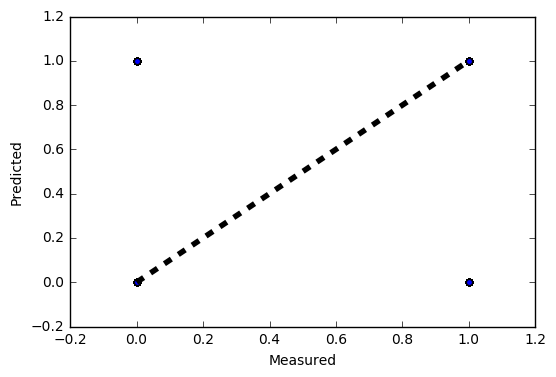

In [64]:
fig, ax = plt.subplots()
ax.scatter(y, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Test with permutations the significance of a classification score

In [69]:
cv = StratifiedKFold(2)

score, permutation_scores, pvalue = permutation_test_score(
    svm, X.reshape(-1, 1), y, scoring="accuracy", cv=cv, n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.660568546853 (pvalue : 0.118811881188)


/home/sabrine/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


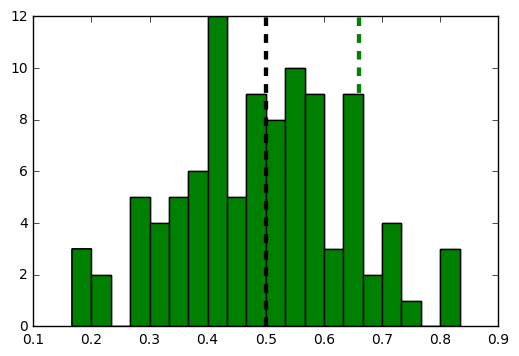

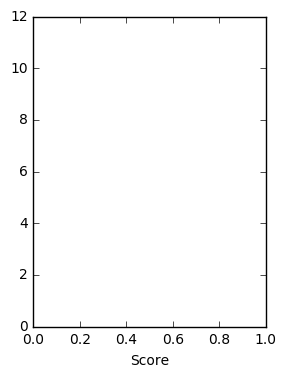

In [73]:
n_classes = 2
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
#plt.vlines(score, ylim[0], ylim[1], linestyle='--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
#plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.figure(figsize=(3,4))

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

Not bad, so I will test it

Learning curve

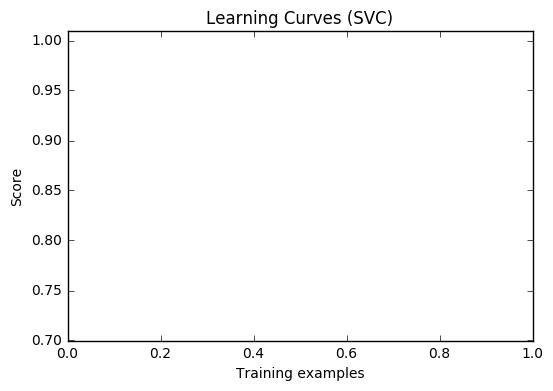

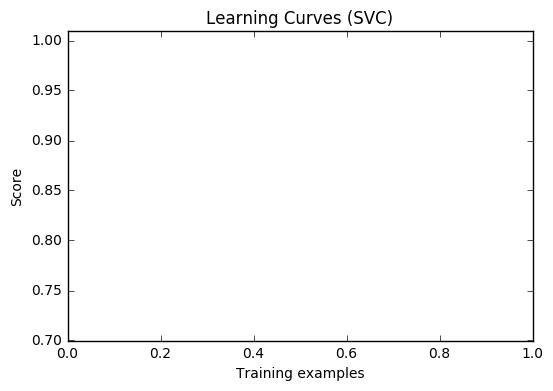

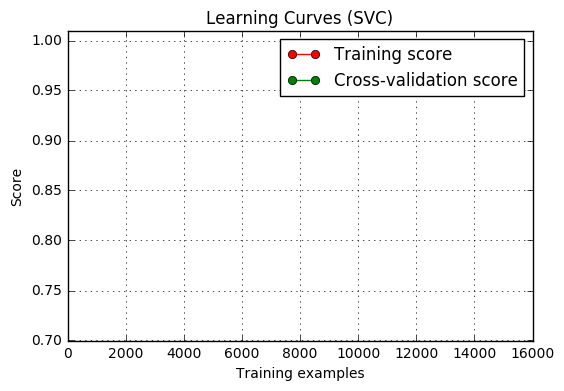

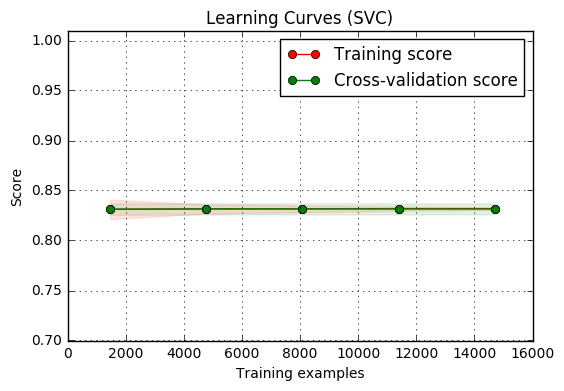

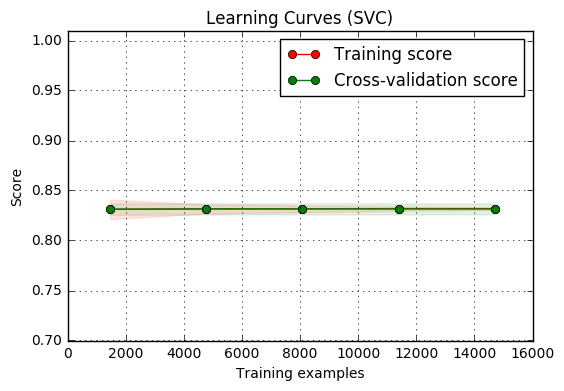

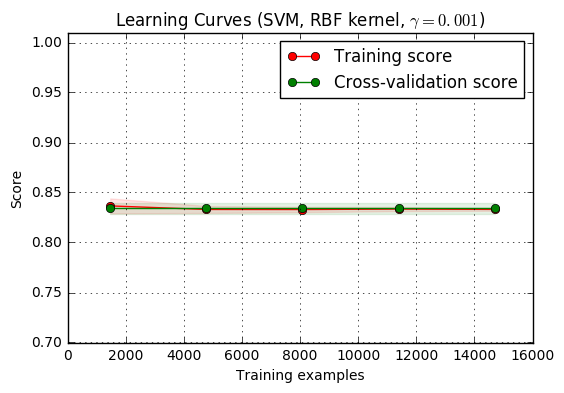

In [84]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (SVC)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X.reshape(-1, 1), y, ylim=(0.7, 1.01), cv=cv, n_jobs=4, verbose=10)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X.reshape(-1, 1), y, (0.7, 1.01), cv=cv, n_jobs=4, verbose = 10)

plt.show()


### Metrics

In [90]:
svm.fit(X.reshape(-1, 1), y)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

In [91]:
confusion_matrix(y, svm.predict(X.reshape(-1, 1)))

array([[10104,  5211],
       [ 1077,  1986]])

In [96]:
# Best metric to evaluate score
f1_score(y, svm.predict(X.reshape(-1, 1)))

0.38713450292397661

### Save model

In [ ]:
# load the model from disk
filename = 'svm.sav'
svm = pickle.load(open(filename, 'rb'))
confusion_matrix(y, svm.predict(X.reshape(-1, 1)))

In [ ]:
# save the model to disk
folderPath = '/home/sabrine/social_tracking/models/svmCosineSimilarity/'
filename = 'svm.sav'
pickle.dump(svm, open(folderPath + filename, 'wb'))
pickle.dump(X.reshape(-1, 1), open(folderPath + 'X', 'wb'))
pickle.dump(y, open(folderPath + 'y', 'wb'))